In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score
)

import matplotlib.pyplot as plt


In [2]:
csv_path = "flight_weather_merged.csv"
df = pd.read_csv(csv_path)

print("✅ CSV 로드 완료")
print("행 수:", len(df))
print("컬럼 수:", df.shape[1])
df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_6360\1893049337.py:2: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


✅ CSV 로드 완료
행 수: 1262522
컬럼 수: 52


,AIRLINE_ENGLISH,AIRLINE_KOREAN,AIRPORT,AIR_FLN,ARRIVED_ENG,ARRIVED_KOR,BAGGAGE_CLAIM,BOARDING_ENG,BOARDING_KOR,CITY,...,3시간신적설(cm),중하층운량(10분위),현상번호(국내식),지면온도(°C),풍속_ms,풍향_deg,시정_m,전운량_okta,1층 운고(FT)_결측여부,weather_datetime
0,AIR SEOUL,에어서울,GMP,RS901,JEJU,제주,NaN,GIMPO,김포,CJU,...,0.0,NaN,0.0,NaN,2.057776,240.0,10000.0,1.0,0.0,2023-04-30 06:00:00
1,JINAIR,진에어,GMP,LJ301,JEJU,제주,NaN,GIMPO,김포,CJU,...,0.0,NaN,0.0,NaN,2.057776,240.0,10000.0,1.0,0.0,2023-04-30 06:00:00
2,ASIANA AIRLINE,아시아나항공,GMP,OZ8937,JEJU,제주,NaN,GIMPO,김포,CJU,...,0.0,NaN,0.0,NaN,2.057776,240.0,10000.0,1.0,0.0,2023-04-30 06:00:00
3,EASTAR JET,이스타항공,GMP,ZE201,JEJU,제주,NaN,GIMPO,김포,CJU,...,0.0,NaN,0.0,NaN,2.057776,240.0,10000.0,1.0,0.0,2023-04-30 06:00:00
4,JINAIR,진에어,GMP,LJ303,JEJU,제주,NaN,GIMPO,김포,CJU,...,0.0,NaN,0.0,NaN,2.057776,240.0,10000.0,1.0,0.0,2023-04-30 06:00:00


In [3]:
def make_delay_label(x):
    if pd.isna(x):
        return 0
    if any(k in x for k in ["지연", "결항", "회항"]):
        return 1
    return 0

df["is_delay"] = df["RMK_KOR"].apply(make_delay_label)
df["is_delay"].value_counts()


0    1250909
1      11613
Name: is_delay, dtype: int64

In [4]:
df["flight_datetime"] = pd.to_datetime(df["flight_datetime"])

df["weekday"] = df["flight_datetime"].dt.weekday
df["month"]   = df["flight_datetime"].dt.month
df["hour"]    = df["flight_datetime"].dt.hour
df["flight_date"] = df["flight_datetime"].dt.date


In [5]:
num_cols = [
    "적설(cm)",
    "풍속_ms",
    "기온(°C)",
    "전운량_okta",
    "강수량(mm)",
    "STD_clean",
    "hour",
    "1층 운고(FT)",
    "이슬점온도(°C)",
    "습도(%)"
]


In [6]:
cat_cols = [
    "AIRLINE_KOREAN",
    "BOARDING_KOR",
    "ARRIVED_KOR",
    "LINE",
    "IO",
    "일기현상",
    "1층 운형"
]


In [7]:
# 실제 존재하는 컬럼만 사용
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

print("📊 수치형:", num_cols)
print("🏷 범주형:", cat_cols)


📊 수치형: ['적설(cm)', '풍속_ms', '기온(°C)', '전운량_okta', '강수량(mm)', 'STD_clean', 'hour', '1층 운고(FT)', '이슬점온도(°C)', '습도(%)']
🏷 범주형: ['AIRLINE_KOREAN', 'BOARDING_KOR', 'ARRIVED_KOR', 'LINE', 'IO', '일기현상', '1층 운형']


In [8]:
# 수치형 → 중앙값
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# 범주형 → UNKNOWN
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")


In [9]:
df = df.sort_values("flight_date")
split_date = df["flight_date"].quantile(0.8)

train_df = df[df["flight_date"] <= split_date]
test_df  = df[df["flight_date"] > split_date]

X_train = train_df[num_cols + cat_cols].copy()
y_train = train_df["is_delay"]

X_test  = test_df[num_cols + cat_cols].copy()
y_test  = test_df["is_delay"]

print("Train:", len(X_train), "Test:", len(X_test))


Train: 1010666 Test: 251856


In [10]:
import sys
!{sys.executable} -m pip install lightgbm


In [11]:
# 🔥 핵심: X_train / X_test에서 category 변환
for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col]  = X_test[col].astype("category")


In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_cols,
    free_raw_data=False
)

lgb_valid = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=cat_cols,
    reference=lgb_train,
    free_raw_data=False
)


In [13]:
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "scale_pos_weight": 70,   # 🔥 여기만 바뀜
    "verbosity": -1
}


In [14]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)


Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.964345	valid's auc: 0.835968
[200]	train's auc: 0.976976	valid's auc: 0.833539
Early stopping, best iteration is:
[140]	train's auc: 0.970445	valid's auc: 0.837314


In [15]:
y_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC :", average_precision_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      0.93      0.97    250885
           1       0.03      0.51      0.06       971

    accuracy                           0.93    251856
   macro avg       0.51      0.72      0.51    251856
weighted avg       0.99      0.93      0.96    251856

ROC-AUC: 0.8373136398898672
PR-AUC : 0.041299142131431245


In [16]:
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    print(f"\n===== Threshold = {t} =====")
    y_pred_t = (y_prob >= t).astype(int)
    print(classification_report(y_test, y_pred_t))



===== Threshold = 0.3 =====
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    250885
           1       0.02      0.67      0.04       971

    accuracy                           0.87    251856
   macro avg       0.51      0.77      0.48    251856
weighted avg       0.99      0.87      0.93    251856


===== Threshold = 0.4 =====
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    250885
           1       0.02      0.58      0.05       971

    accuracy                           0.91    251856
   macro avg       0.51      0.74      0.50    251856
weighted avg       0.99      0.91      0.95    251856


===== Threshold = 0.5 =====
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    250885
           1       0.03      0.51      0.06       971

    accuracy                           0.93    251856
   macro avg       0.51      0.72      0.

In [17]:
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance(importance_type="gain")
}).sort_values("importance", ascending=False)

importance_df.head(20)


,feature,importance
15,일기현상,4.789044e+06
8,이슬점온도(°C),4.163945e+06
3,전운량_okta,2.650388e+06
5,STD_clean,1.689890e+06
12,ARRIVED_KOR,1.677930e+06
1,풍속_ms,1.345356e+06
9,습도(%),1.179356e+06
7,1층_운고(FT),7.945920e+05
2,기온(°C),7.837562e+05
10,AIRLINE_KOREAN,7.070011e+05


C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font

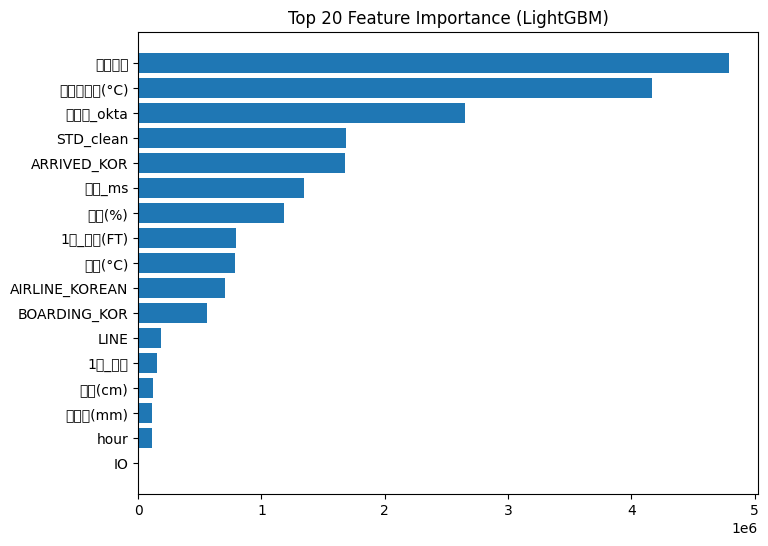

In [18]:
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df.head(20)["feature"][::-1],
    importance_df.head(20)["importance"][::-1]
)
plt.title("Top 20 Feature Importance (LightGBM)")
plt.show()
